##### Good resource: https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [3]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [4]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [5]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [6]:
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed


In [7]:
#Apply standardizing functions to synopsis and critic text
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   

                                              genres          directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...     Chris Columbus   
1                                             Comedy  Nicole Holofcener   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   
1                           Nicole Holofcener   

                                              actors original_release_date  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...            2010-02-12   
1  Catherine Keener, Amanda Peet, Oliver Platt, R...            2010-04-30   

  streaming_release_date  ...  num_actors num_actors_group  \
0             2015-11-25  ...        87.0           50-100   
1             2012-09-04  ...         8.0            10-25   

                                  cleaned_movie_info  \
0  always trouble prone life teenager percy jacks...   
1  kate catherine keener husband alex oliver plat...   

                           cleaned_critics_consensus  \
0  though may seem like another harry potter knoc...   
1  nicole holofcener newest might seem slight pla...   

                              synposis_scores_unpack  \
0  {'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...   
1  {'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...   

                                critic_scores_unpack  \
0  {'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...   
1  {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...   

   synopsis_sentiment_score  synopsis_sentiment_class  critic_sentiment_score  \
0                   -0.2023                         0                  0.9274   
1                    0.2023                         1                  0.3612   

   critic_sentiment_class  
0                       1  
1                       1  

[2 rows x 34 columns]

### Time Series Forecasting

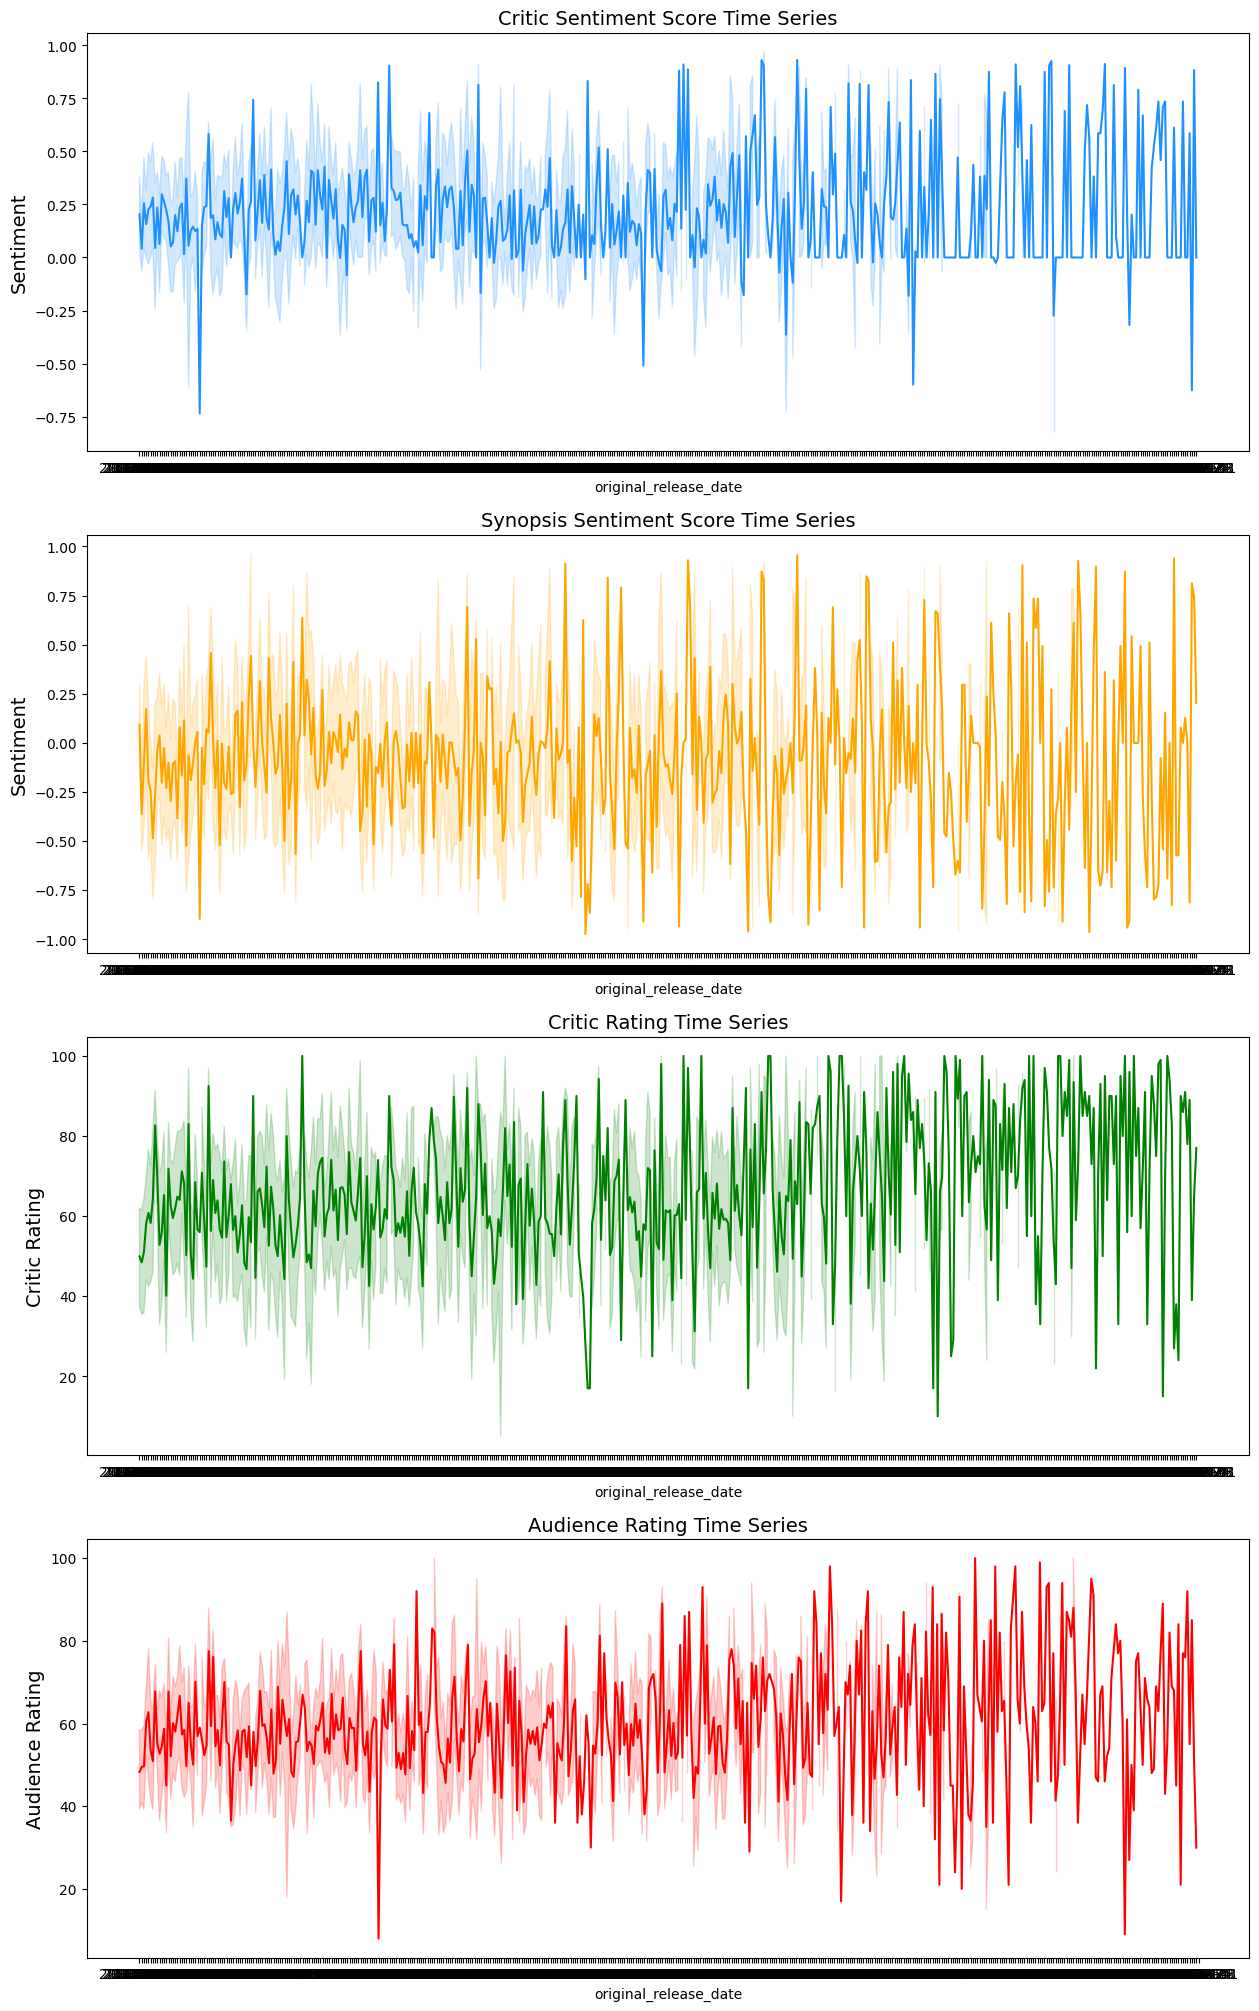

In [10]:
import seaborn as sns

plot_df = df[(df['original_release_date']>='2015-01-01') & ((df['original_release_date']<='2020-01-01'))]

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.lineplot(x=plot_df['original_release_date'], y=plot_df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
ax[0].set_title('Critic Sentiment Score Time Series', fontsize=14)
ax[0].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=plot_df['original_release_date'], y=plot_df['synopsis_sentiment_score'], ax=ax[1], color='orange')
ax[1].set_title('Synopsis Sentiment Score Time Series', fontsize=14)
ax[1].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=plot_df['original_release_date'], y=plot_df['tomatometer_rating'], ax=ax[2], color='green')
ax[2].set_title('Critic Rating Time Series', fontsize=14)
ax[2].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=plot_df['original_release_date'], y=plot_df['audience_rating'], ax=ax[3], color='red')
ax[3].set_title('Audience Rating Time Series', fontsize=14)
ax[3].set_ylabel(ylabel='Audience Rating', fontsize=14)

plt.show()

## Data Preprocessing

#### The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see Resampling).

In [11]:
#Filter data where intervals are all in one month range
time_df = df[df['original_release_date']>='1971-01-01']
time_df = time_df.sort_values(by='original_release_date')

#Create the year-month variable
time_df['original_release_ym'] =  pd.to_datetime(time_df['original_release_date'])
time_df['original_release_ym'] = time_df['original_release_ym'].dt.strftime('%Y-%m')
time_df['original_release_ym'] =  pd.to_datetime(time_df['original_release_ym'])

#Create new dataframe 
ym_df = time_df.groupby('original_release_ym').agg({
    'critic_sentiment_score': 'mean',
    'synopsis_sentiment_score':'mean',
    'tomatometer_rating':'mean',
    'audience_rating':'mean'
}).reset_index()

ym_df.head()

original_release_ym  critic_sentiment_score  synopsis_sentiment_score  \
0          1971-01-01                0.019210                 -0.306400   
1          1971-02-01                0.153100                 -0.543250   
2          1971-03-01                0.161767                  0.286833   
3          1971-04-01                0.000000                  0.152340   
4          1971-05-01                0.111480                  0.483580   

   tomatometer_rating  audience_rating  
0           80.100000        71.300000  
1           61.750000        60.000000  
2           82.166667        69.166667  
3           50.600000        49.800000  
4           54.600000        52.200000

In [12]:
ym_df.dtypes

original_release_ym         datetime64[ns]
critic_sentiment_score             float64
synopsis_sentiment_score           float64
tomatometer_rating                 float64
audience_rating                    float64
dtype: object

In [13]:
# Check time intervals
ym_df['time_interval'] = ym_df['original_release_ym'] - ym_df['original_release_ym'].shift(1)
ym_df['time_interval'].value_counts()

31 days    348
30 days    198
28 days     37
29 days     13
Name: time_interval, dtype: int64

In [14]:
ym_df.isnull().sum()

original_release_ym         0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             0
time_interval               1
dtype: int64

In [15]:
del ym_df['time_interval']

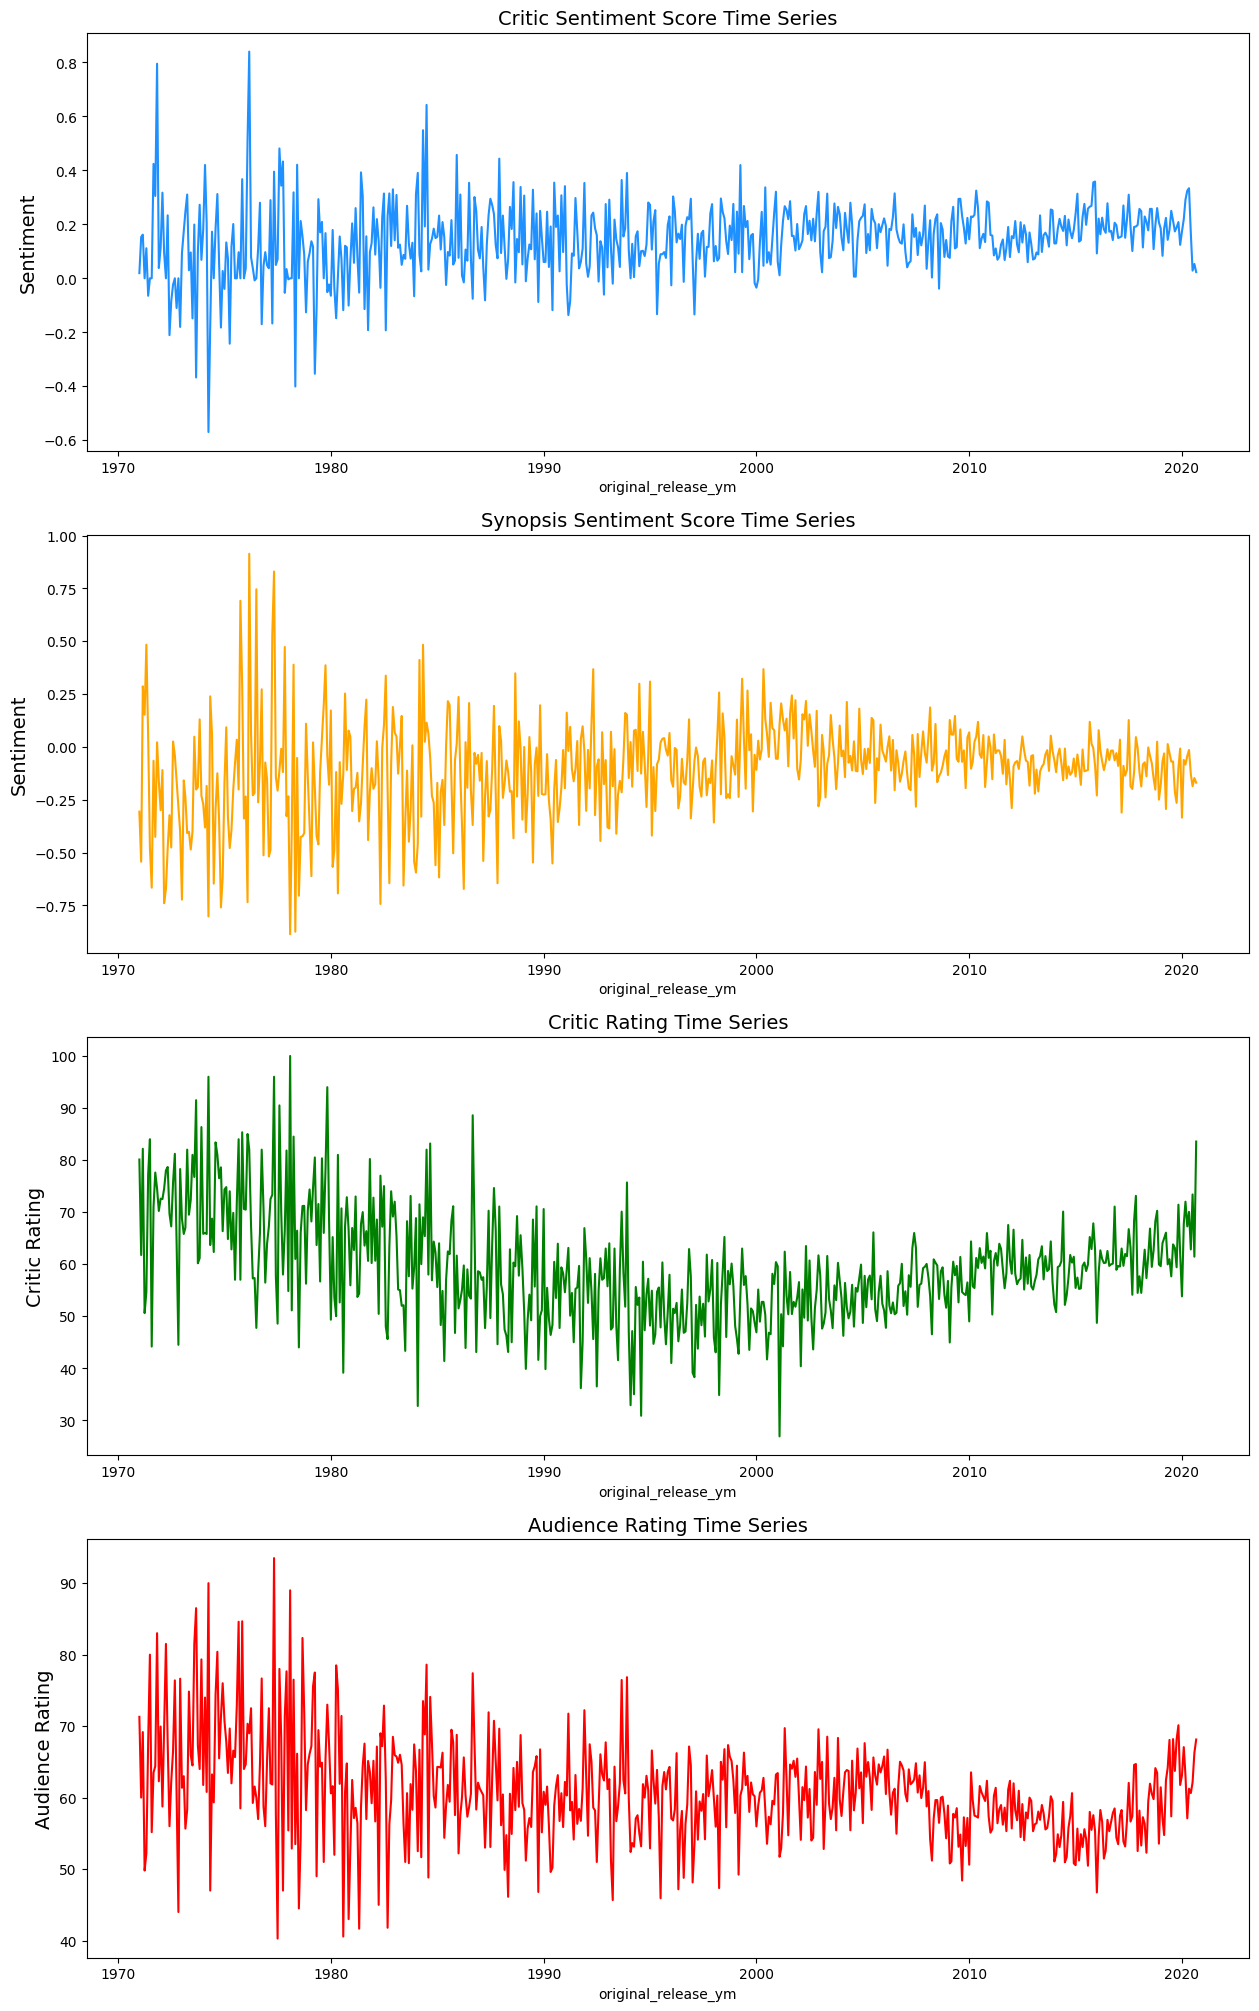

In [16]:
import seaborn as sns

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
ax[0].set_title('Critic Sentiment Score Time Series', fontsize=14)
ax[0].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'], ax=ax[1], color='orange')
ax[1].set_title('Synopsis Sentiment Score Time Series', fontsize=14)
ax[1].set_ylabel(ylabel='Sentiment', fontsize=14)


sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'], ax=ax[2], color='green')
ax[2].set_title('Critic Rating Time Series', fontsize=14)
ax[2].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'], ax=ax[3], color='red')
ax[3].set_title('Audience Rating Time Series', fontsize=14)
ax[3].set_ylabel(ylabel='Audience Rating', fontsize=14)

plt.show()

### Stationarity


#### Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

##### a.) constant mean and mean is not time-dependent
##### b.) constant variance and variance is not time-dependent
##### c.) constant covariance and covariance is not time-dependent

#### If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

#### Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

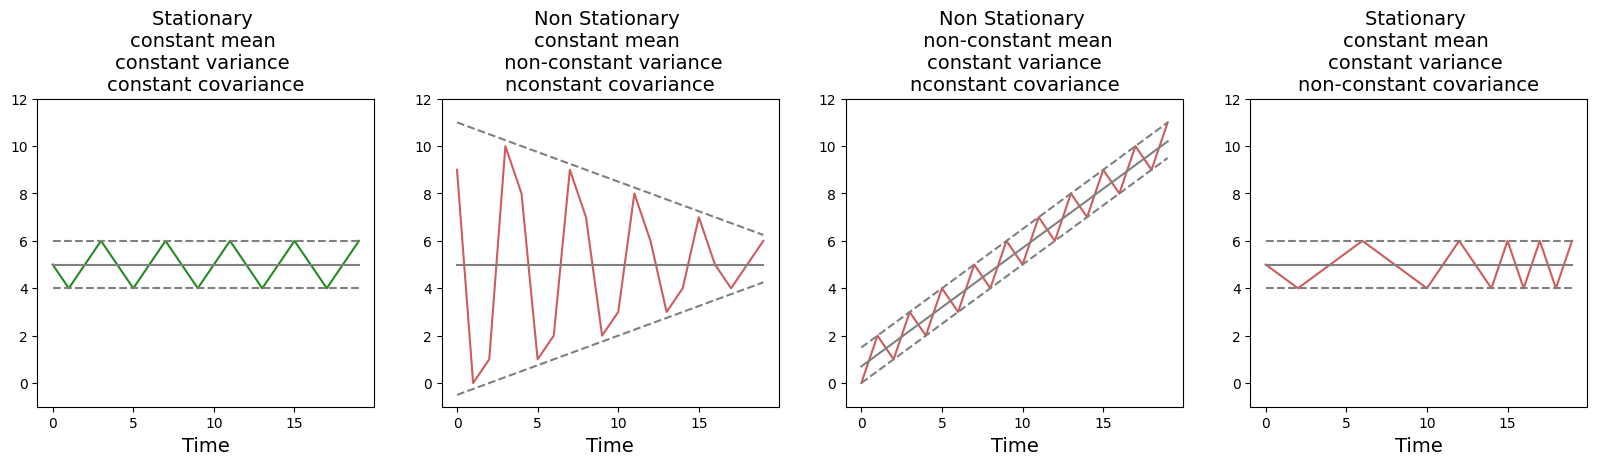

In [17]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

#### The check for stationarity can be done via three different approaches:

#### a.) visually: plot time series and check for trends or seasonality
#### b.) basic statistics: split time series and compare the mean and variance of each partition
#### c.) statistical test: Augmented Dickey Fuller test

In [18]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

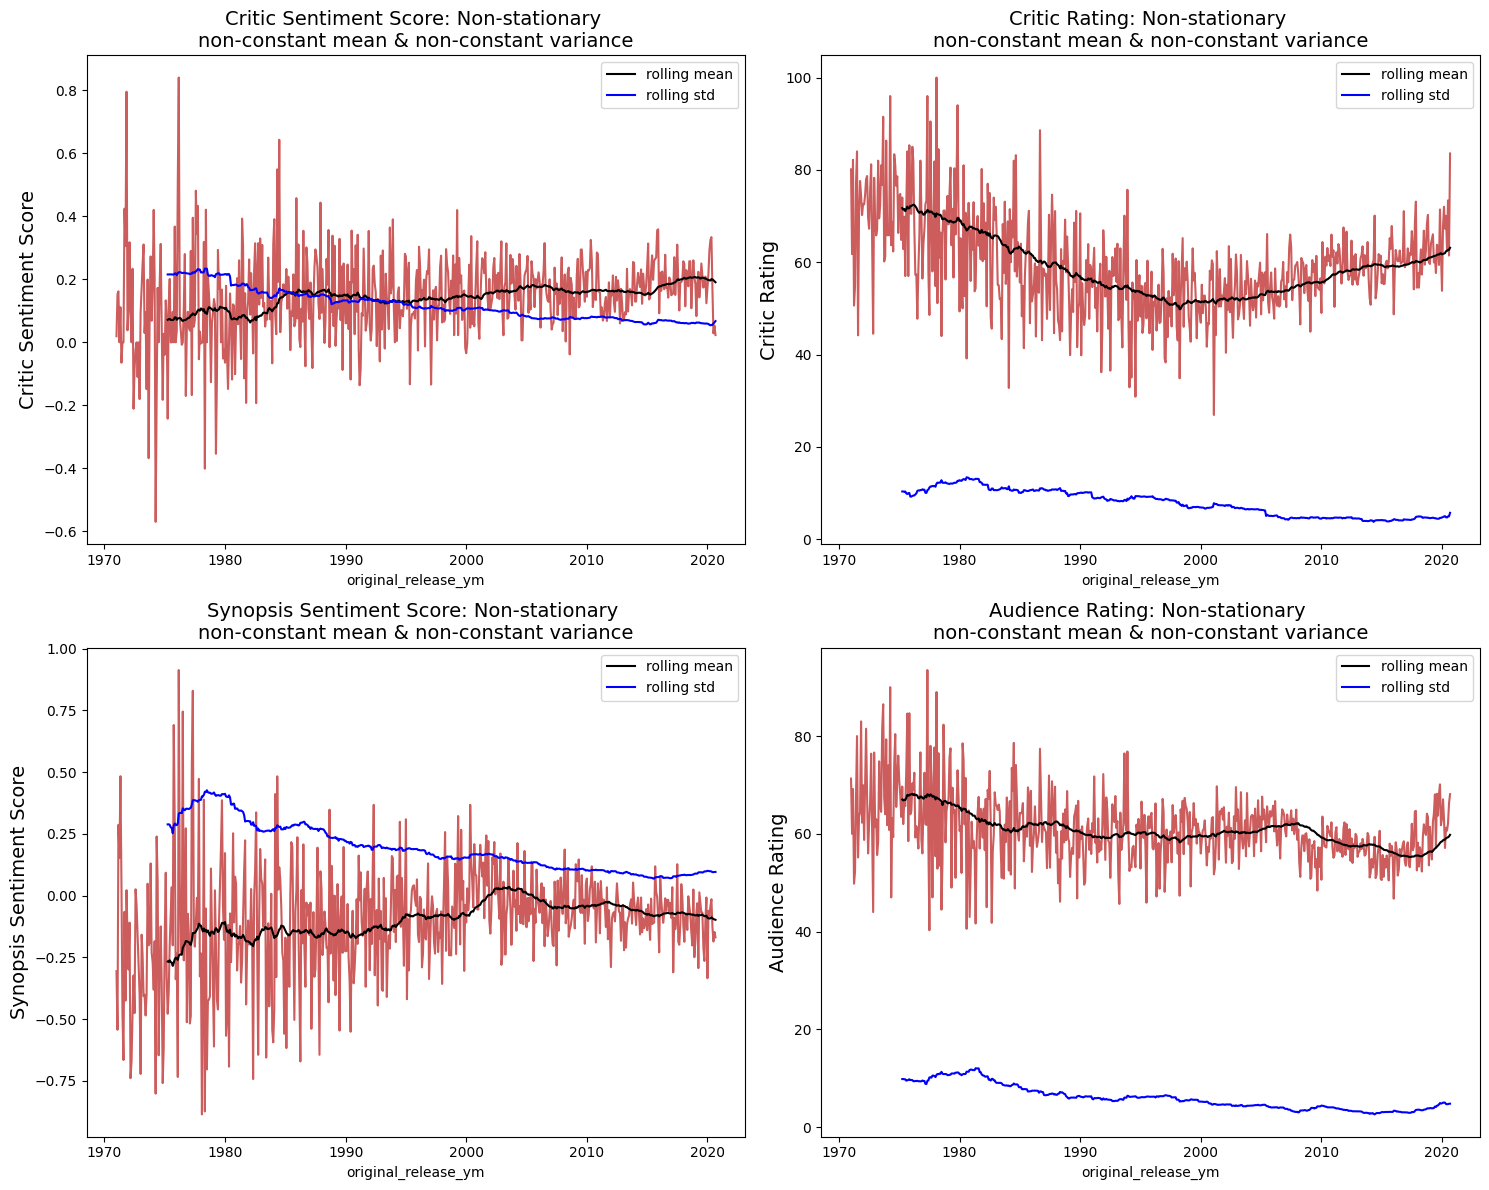

In [19]:
#Visual Test --> they all don't seem stationary, means and variances move around a bit
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'], ax=ax[0, 0], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'].rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['critic_sentiment_score'].rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Critic Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'], ax=ax[1, 0], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'].rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['synopsis_sentiment_score'].rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Synopsis Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Synopsis Sentiment Score', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'], ax=ax[0, 1], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'].rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['tomatometer_rating'].rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Critic Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'], ax=ax[1, 1], color='indianred')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'].rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['audience_rating'].rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Audience Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Audience Rating', fontsize=14)


plt.tight_layout()
plt.show()

In [20]:
#Test #2: Underlying Statistics --> sentiment scores seem stationary as not much difference between chunks
num_partitions = 2
partition_length = int(len(ym_df) / num_partitions)

partition1_mean = ym_df.head(partition_length).mean()
partition1_var = ym_df.head(partition_length).var()
partition2_mean = ym_df.tail(partition_length).mean()
partition2_var = ym_df.tail(partition_length).var()

In [21]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")


In [22]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

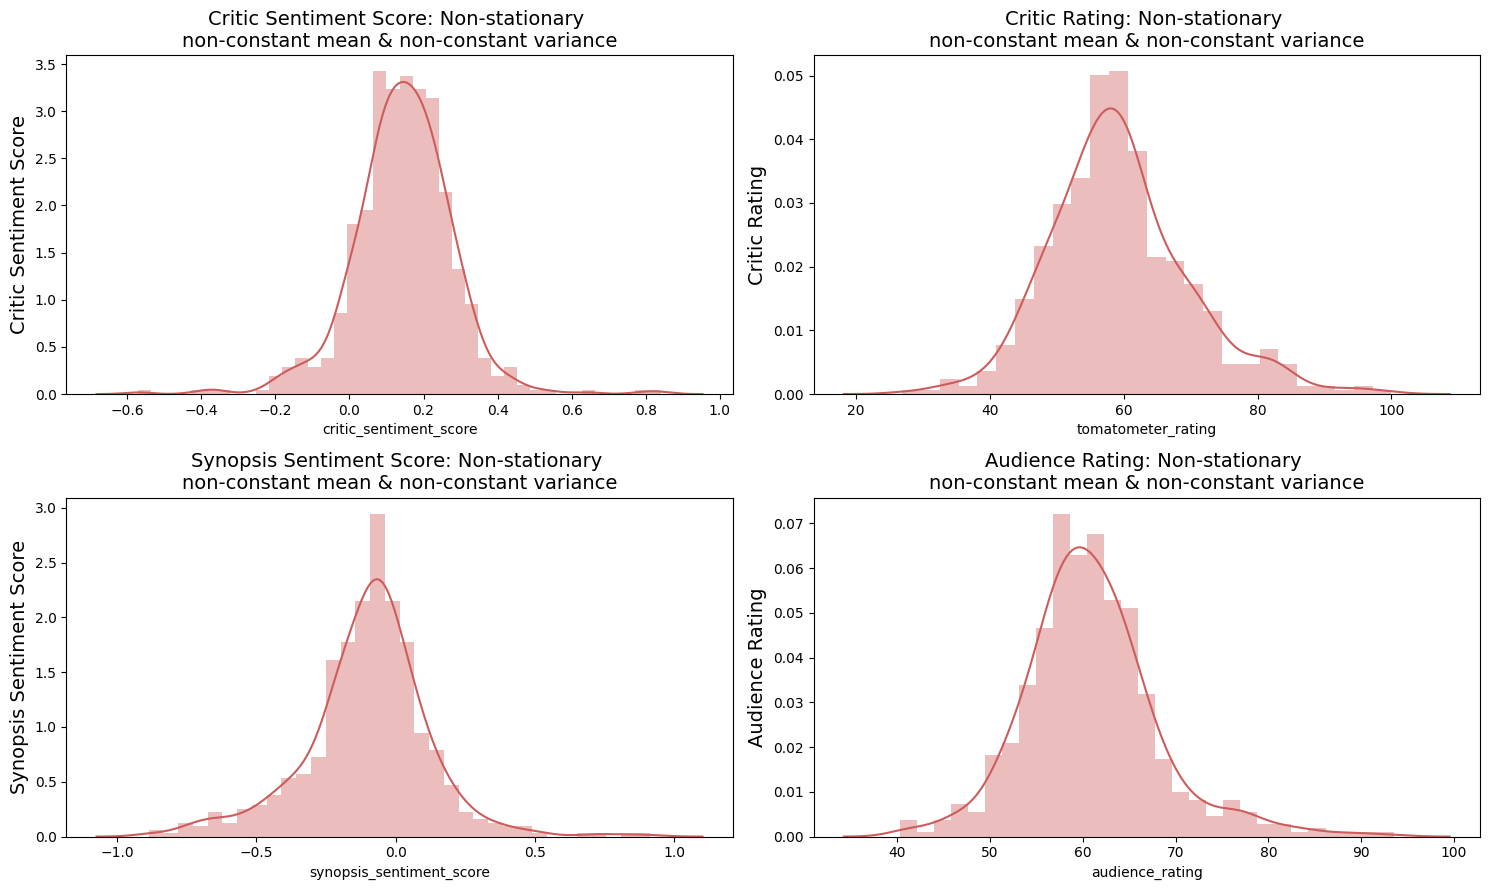

In [23]:
#Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting 
#that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

sns.distplot(ym_df['critic_sentiment_score'], ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Critic Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

sns.distplot(ym_df['synopsis_sentiment_score'], ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Synopsis Sentiment Score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Synopsis Sentiment Score', fontsize=14)

sns.distplot(ym_df['tomatometer_rating'], ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Critic Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.distplot(ym_df['audience_rating'], ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Audience Rating: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Audience Rating', fontsize=14)


plt.tight_layout()
plt.show()


## Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

#### Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

#### Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

#### If the null hypothesis can be rejected, we can conclude that the time series is stationary.

In [24]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

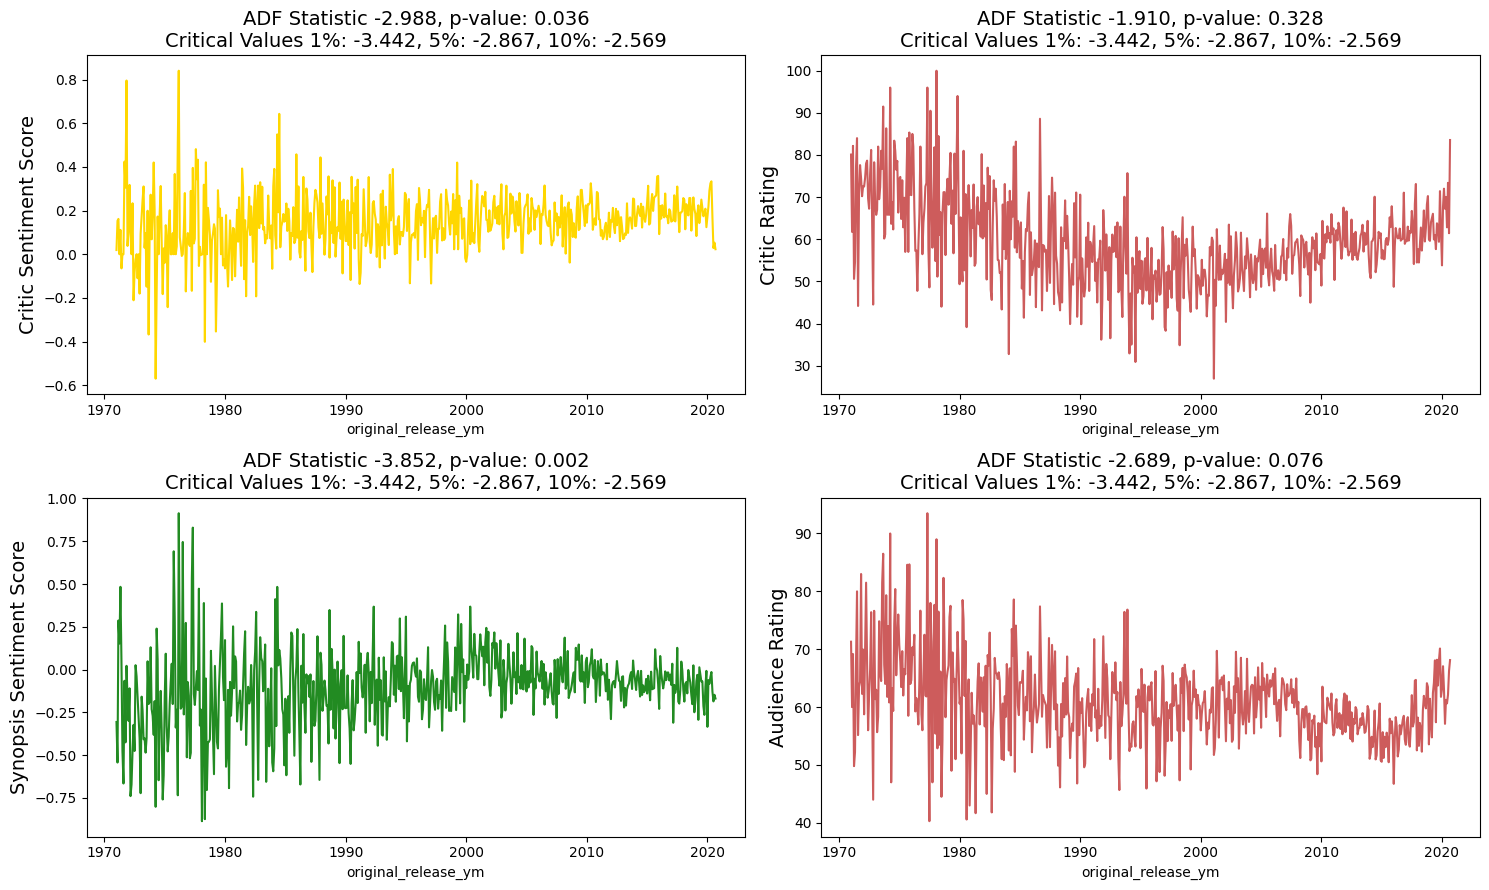

In [25]:
from statsmodels.tsa.stattools import adfuller

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=ym_df['original_release_ym'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(ym_df['critic_sentiment_score'].values, 'Critic Sentiment Score', ax[0, 0])
visualize_adfuller_results(ym_df['synopsis_sentiment_score'].values, 'Synopsis Sentiment Score', ax[1, 0])
visualize_adfuller_results(ym_df['tomatometer_rating'].values, 'Critic Rating', ax[0, 1])
visualize_adfuller_results(ym_df['audience_rating'].values, 'Audience Rating', ax[1, 1])

plt.tight_layout()
plt.show()

In [26]:
#Sentiment scores --> stationary
#critic and audience ratings --> not stationary

#### If the data is not stationary, the data has to be transformed. However, if the data is not stationary to begin with, we should rethink the choice of model.

#### The two most common methods to achieve stationarity are:

#### a.) Transformation: e.g. log or square root to stabilize non-constant variance
#### b.) Differencing: subtracts the current value from the previous

In [27]:
# Log Transform of absolute values
ym_df['tomatometer_rating_log'] = np.log(abs(ym_df['tomatometer_rating']))
ym_df['audience_rating_log'] = np.log(abs(ym_df['audience_rating']))

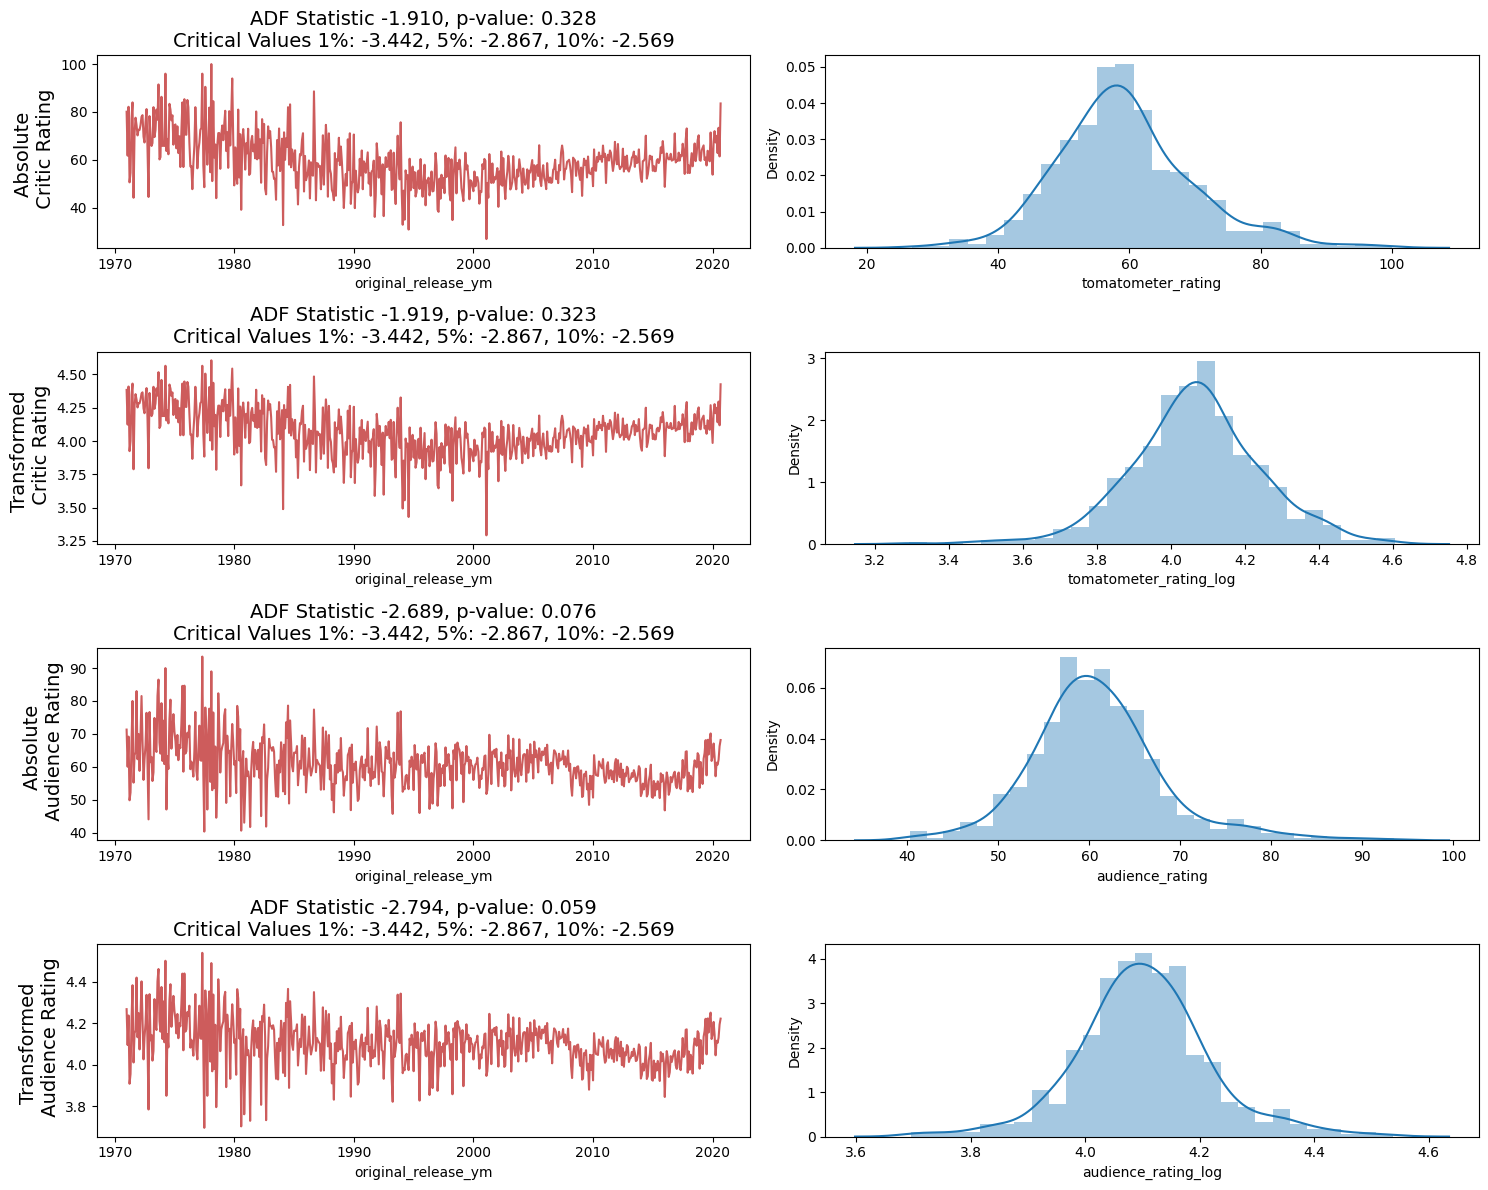

In [28]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

#----------Plot normal vs. transformed critic rating----------#
visualize_adfuller_results(abs(ym_df['tomatometer_rating']), 'Absolute \n Critic Rating', ax[0, 0])
sns.distplot(ym_df['tomatometer_rating'], ax=ax[0, 1])

visualize_adfuller_results(ym_df['tomatometer_rating_log'], 'Transformed \n Critic Rating', ax[1, 0])
sns.distplot(ym_df['tomatometer_rating_log'], ax=ax[1, 1])


#----------Plot normal vs. transformed audience rating----------#
visualize_adfuller_results(abs(ym_df['audience_rating']), 'Absolute \n Audience Rating', ax[2, 0])
sns.distplot(ym_df['audience_rating'], ax=ax[2, 1])

visualize_adfuller_results(ym_df['audience_rating_log'], 'Transformed \n Audience Rating', ax[3, 0])
sns.distplot(ym_df['audience_rating_log'], ax=ax[3, 1])

plt.tight_layout()
plt.show()

In [29]:
#1.) First Order Differencing - Critic Rating
ts_diff = np.diff(ym_df['tomatometer_rating'])
ym_df['tomatometer_rating_diff1'] = np.append([0], ts_diff)

#2.) Second Order Differencing - Critic Rating
ts_diff = np.diff(ym_df['tomatometer_rating_diff1'])
ym_df['tomatometer_rating_diff2'] = np.append([0], ts_diff)

#3.) First Order Differencing - Audience Rating
ts_diff = np.diff(ym_df['audience_rating'])
ym_df['audience_rating_diff1'] = np.append([0], ts_diff)

#4.) Second Order Differencing - Audience Rating
ts_diff = np.diff(ym_df['audience_rating_diff1'])
ym_df['audience_rating_diff2'] = np.append([0], ts_diff)

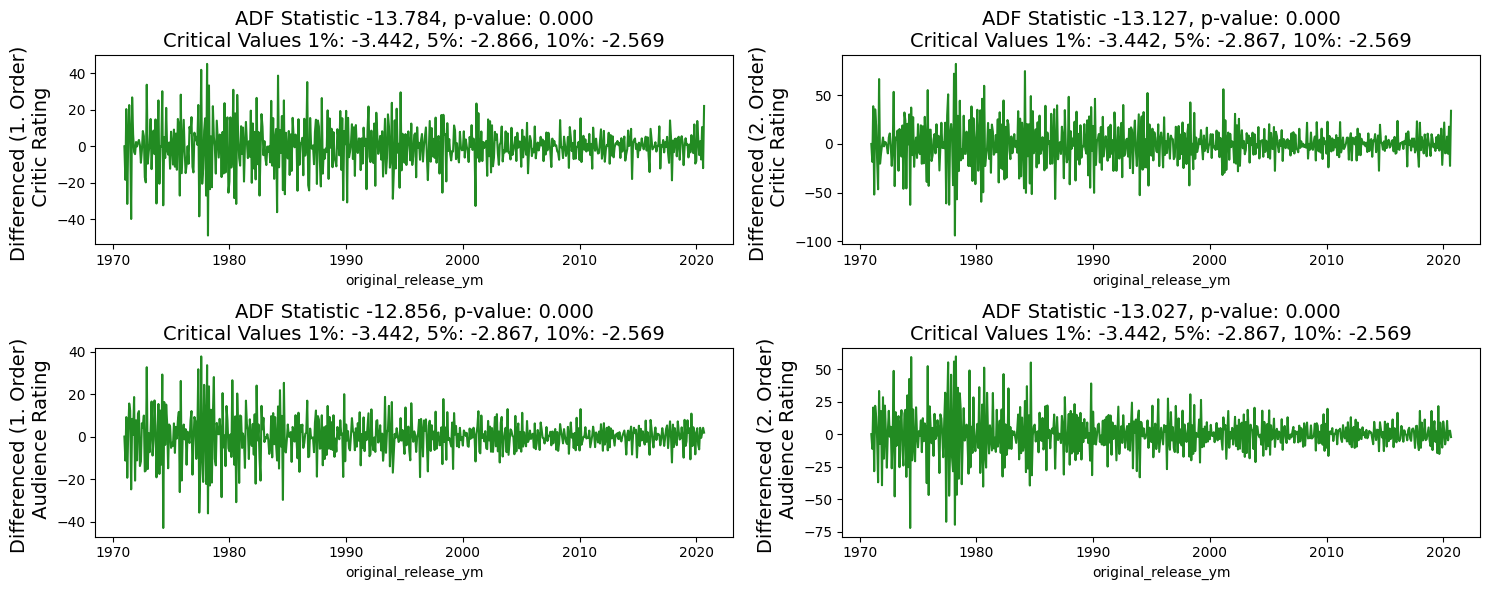

CPU times: user 1.58 s, sys: 526 ms, total: 2.1 s
Wall time: 427 ms


In [30]:
%%time

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

visualize_adfuller_results(ym_df['tomatometer_rating_diff1'], 'Differenced (1. Order) \n Critic Rating', ax[0,0])
visualize_adfuller_results(ym_df['tomatometer_rating_diff2'], 'Differenced (2. Order) \n Critic Rating', ax[0,1])
visualize_adfuller_results(ym_df['audience_rating_diff1'], 'Differenced (1. Order) \n Audience Rating', ax[1,0])
visualize_adfuller_results(ym_df['audience_rating_diff2'], 'Differenced (2. Order) \n Audience Rating', ax[1,1])

plt.tight_layout()
plt.show()

## Feature Engineering

In [33]:
ym_df['year'] = pd.DatetimeIndex(ym_df['original_release_ym']).year
ym_df['month'] = pd.DatetimeIndex(ym_df['original_release_ym']).month
ym_df['quarter'] = pd.DatetimeIndex(ym_df['original_release_ym']).quarter
ym_df['season'] = ym_df.month%12 // 3 + 1

ym_df[['original_release_ym','year', 'month', 'quarter', 'season']].head()

original_release_ym  year  month  quarter  season
0          1971-01-01  1971      1        1       1
1          1971-02-01  1971      2        1       1
2          1971-03-01  1971      3        1       2
3          1971-04-01  1971      4        2       2
4          1971-05-01  1971      5        2       2

## Encoding Cyclical Features¶
#### The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

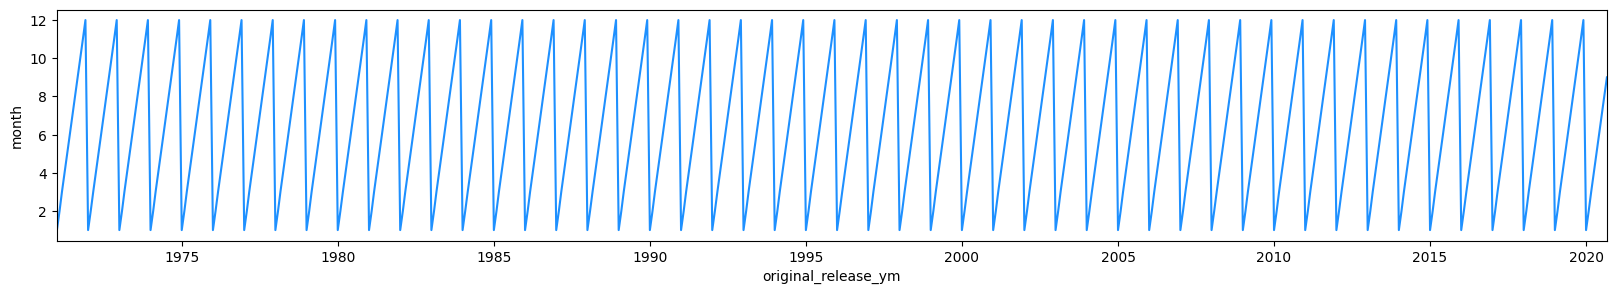

In [37]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=ym_df['original_release_ym'], y=ym_df['month'], color='dodgerblue')
ax.set_xlim([ym_df['original_release_ym'].min(),ym_df['original_release_ym'].max()])
plt.show()

#### Ideally, we want the underlying data to represent the same difference between two consecutive months, even between December and January. A common remedy for this issue is to encode cyclical features into two dimensions with sine and cosine transformation.

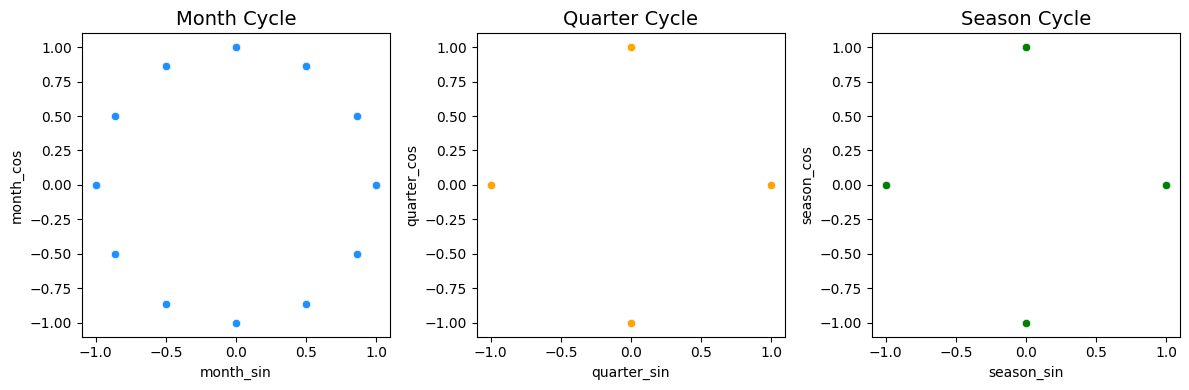

In [57]:
month_in_year = 12
ym_df['month_sin'] = np.sin(2*np.pi*ym_df.month/month_in_year)
ym_df['month_cos'] = np.cos(2*np.pi*ym_df.month/month_in_year)

quarters_in_year = 4
ym_df['quarter_sin'] = np.sin(2*np.pi*ym_df.quarter/quarters_in_year)
ym_df['quarter_cos'] = np.cos(2*np.pi*ym_df.quarter/quarters_in_year)

seasons_in_year = 4
ym_df['season_sin'] = np.sin(2*np.pi*ym_df.season/seasons_in_year)
ym_df['season_cos'] = np.cos(2*np.pi*ym_df.season/seasons_in_year)


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.scatterplot(x=ym_df.month_sin, y=ym_df.month_cos, ax=ax[0], color='dodgerblue')
ax[0].set_title('Month Cycle', fontsize=14)

sns.scatterplot(x=ym_df.quarter_sin, y=ym_df.quarter_cos, ax=ax[1], color='orange')
ax[1].set_title('Quarter Cycle', fontsize=14)

sns.scatterplot(x=ym_df.season_sin, y=ym_df.season_cos, ax=ax[2], color='green')
ax[2].set_title('Season Cycle', fontsize=14)
plt.tight_layout()
plt.show()

### Decomposition
##### The characteristics of a time series are

#### (1) Trend and Level, (2) Seasonality, (3) Random / Noise
#### We can use the function seasonal_decompose() from the statsmodels library.

#### Additive:  𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙+𝑇𝑟𝑒𝑛𝑑+𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦+𝑁𝑜𝑖𝑠𝑒 
#### Multiplicative:  𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙∗𝑇𝑟𝑒𝑛𝑑∗𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦∗𝑁𝑜𝑖𝑠𝑒

In [58]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating',
       'tomatometer_rating_log', 'audience_rating_log',
       'tomatometer_rating_diff1', 'tomatometer_rating_diff2',
       'audience_rating_diff1', 'audience_rating_diff2', 'year', 'month',
       'quarter', 'season', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos', 'season_sin', 'season_cos'],
      dtype='object')

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  ['critic_sentiment_score', 'synopsis_sentiment_score', 
                   'tomatometer_rating', 'audience_rating']

for col in decompose_cols:
    decomp = seasonal_decompose(ym_df[col], period=52, model='additive', extrapolate_trend='freq')
    ym_df[f"{col}_trend"] = decomp.trend
    ym_df[f"{col}_seasonal"] = decomp.seasonal

In [62]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating',
       'tomatometer_rating_log', 'audience_rating_log',
       'tomatometer_rating_diff1', 'tomatometer_rating_diff2',
       'audience_rating_diff1', 'audience_rating_diff2', 'year', 'month',
       'quarter', 'season', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos', 'season_sin', 'season_cos',
       'critic_sentiment_score_trend', 'critic_sentiment_score_seasonal',
       'synopsis_sentiment_score_trend', 'synopsis_sentiment_score_seasonal',
       'tomatometer_rating_trend', 'tomatometer_rating_seasonal',
       'audience_rating_trend', 'audience_rating_seasonal'],
      dtype='object')

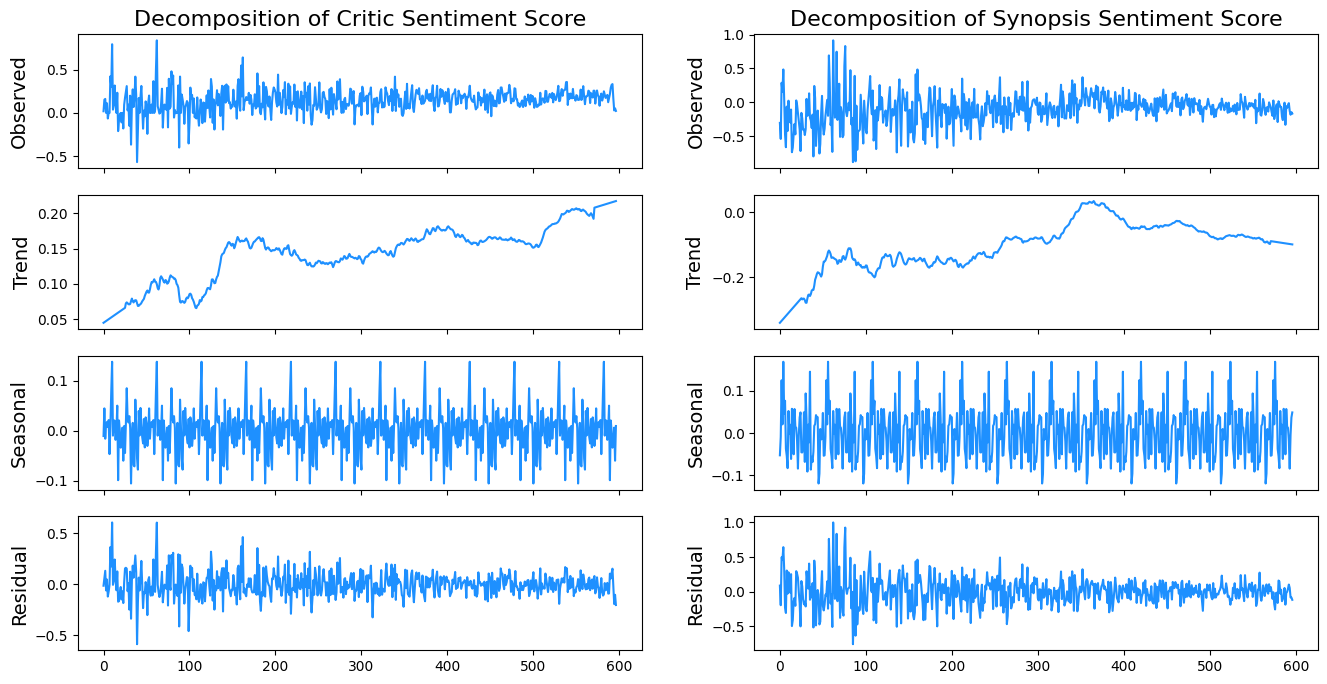

In [64]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
#------------------------------------#

res = seasonal_decompose(ym_df['critic_sentiment_score'], period=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Critic Sentiment Score', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)

#------------------------------------#
ax[0,1].set_title('Decomposition of Synopsis Sentiment Score', fontsize=16)
res = seasonal_decompose(ym_df['synopsis_sentiment_score'], period=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

In [65]:
ym_df.columns

Index(['original_release_ym', 'critic_sentiment_score',
       'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating',
       'tomatometer_rating_log', 'audience_rating_log',
       'tomatometer_rating_diff1', 'tomatometer_rating_diff2',
       'audience_rating_diff1', 'audience_rating_diff2', 'year', 'month',
       'quarter', 'season', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos', 'season_sin', 'season_cos',
       'critic_sentiment_score_trend', 'critic_sentiment_score_seasonal',
       'synopsis_sentiment_score_trend', 'synopsis_sentiment_score_seasonal',
       'tomatometer_rating_trend', 'tomatometer_rating_seasonal',
       'audience_rating_trend', 'audience_rating_seasonal'],
      dtype='object')

In [67]:
ym_df[['critic_sentiment_score', 'critic_sentiment_score_trend', 'critic_sentiment_score_seasonal', 
    'synopsis_sentiment_score', 'synopsis_sentiment_score_trend', 'synopsis_sentiment_score_seasonal', 
    'tomatometer_rating', 'tomatometer_rating_trend', 'tomatometer_rating_seasonal',
    'audience_rating', 'audience_rating_trend', 'audience_rating_seasonal',

          ]].head()\
.style.set_properties(subset=['critic_sentiment_score_trend', 'critic_sentiment_score_seasonal', 
                              'synopsis_sentiment_score_trend', 'synopsis_sentiment_score_seasonal', 
                              'tomatometer_rating_trend', 'tomatometer_rating_seasonal', 
                              'audience_rating_trend', 'audience_rating_seasonal',
                             ], **{'background-color': 'dodgerblue'})

### Lag

In [70]:
weeks_in_month = 4

ym_df['critic_sentiment_score_seasonal_shift_r_2M'] = ym_df['critic_sentiment_score_seasonal'].shift(-2*weeks_in_month)
ym_df['critic_sentiment_score_seasonal_shift_r_1M'] = ym_df['critic_sentiment_score_seasonal'].shift(-1*weeks_in_month)
ym_df['critic_sentiment_score_seasonal_shift_1M'] = ym_df['critic_sentiment_score_seasonal'].shift(1*weeks_in_month)
ym_df['critic_sentiment_score_seasonal_shift_2M'] = ym_df['critic_sentiment_score_seasonal'].shift(2*weeks_in_month)
ym_df['critic_sentiment_score_seasonal_shift_3M'] = ym_df['critic_sentiment_score_seasonal'].shift(3*weeks_in_month)

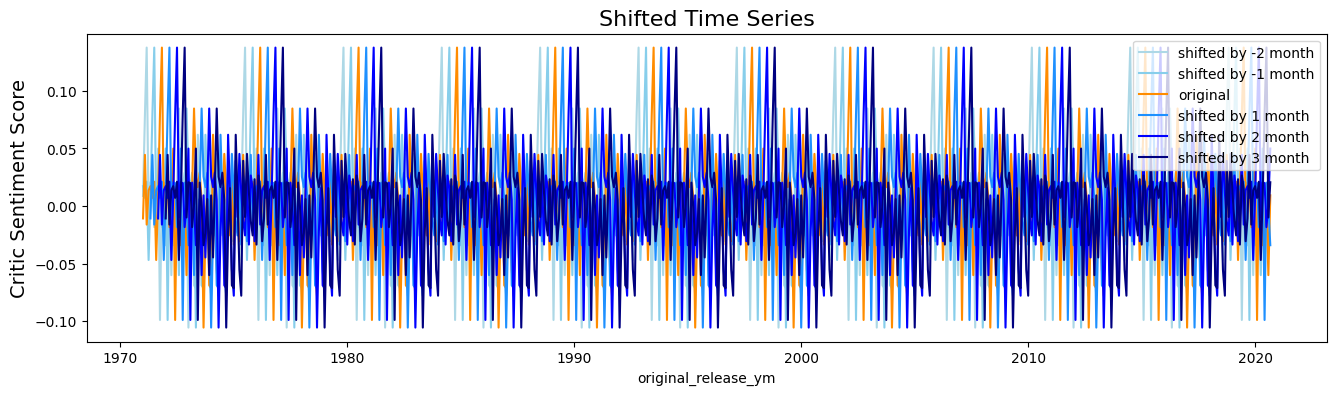

In [82]:
ym_df['synopsis_sentiment_score_seasonal_shift_r_2M'] = ym_df['synopsis_sentiment_score_seasonal'].shift(-2*weeks_in_month)
ym_df['synopsis_sentiment_score_seasonal_shift_r_1M'] = ym_df['synopsis_sentiment_score_seasonal'].shift(-1*weeks_in_month)
ym_df['synopsis_sentiment_score_seasonal_shift_1M'] = ym_df['synopsis_sentiment_score_seasonal'].shift(1*weeks_in_month)
ym_df['synopsis_sentiment_score_seasonal_shift_2M'] = ym_df['synopsis_sentiment_score_seasonal'].shift(2*weeks_in_month)
ym_df['synopsis_sentiment_score_seasonal_shift_3M'] = ym_df['synopsis_sentiment_score_seasonal'].shift(3*weeks_in_month)

ym_df['tomatometer_rating_seasonal_shift_r_2M'] = ym_df['tomatometer_rating_seasonal'].shift(-2*weeks_in_month)
ym_df['tomatometer_rating_seasonal_shift_r_1M'] = ym_df['tomatometer_rating_seasonal'].shift(-1*weeks_in_month)
ym_df['tomatometer_rating_seasonal_shift_1M'] = ym_df['tomatometer_rating_seasonal'].shift(1*weeks_in_month)
ym_df['tomatometer_rating_seasonal_shift_2M'] = ym_df['tomatometer_rating_seasonal'].shift(2*weeks_in_month)
ym_df['tomatometer_rating_seasonal_shift_3M'] = ym_df['tomatometer_rating_seasonal'].shift(3*weeks_in_month)

ym_df['audience_rating_seasonal_shift_r_2M'] = ym_df['audience_rating_seasonal'].shift(-2*weeks_in_month)
ym_df['audience_rating_seasonal_shift_r_1M'] = ym_df['audience_rating_seasonal'].shift(-1*weeks_in_month)
ym_df['audience_rating_seasonal_shift_1M'] = ym_df['audience_rating_seasonal'].shift(1*weeks_in_month)
ym_df['audience_rating_seasonal_shift_2M'] = ym_df['audience_rating_seasonal'].shift(2*weeks_in_month)
ym_df['audience_rating_seasonal_shift_3M'] = ym_df['audience_rating_seasonal'].shift(3*weeks_in_month)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal_shift_r_2M, label='shifted by -2 month', ax=ax, color='lightblue')
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal_shift_r_1M, label='shifted by -1 month', ax=ax, color='skyblue')
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal, label='original', ax=ax, color='darkorange')
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal_shift_1M, label='shifted by 1 month', ax=ax, color='dodgerblue')
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal_shift_2M, label='shifted by 2 month', ax=ax, color='blue')
sns.lineplot(x=ym_df.original_release_ym, y=ym_df.critic_sentiment_score_seasonal_shift_3M, label='shifted by 3 month', ax=ax, color='navy')

ax.set_title('Shifted Time Series', fontsize=16)
ax.set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

plt.show()

# Exploratory Data Analysis
### Let's begin by plotting the seasonal components of each feature and comparing the minima and maxima

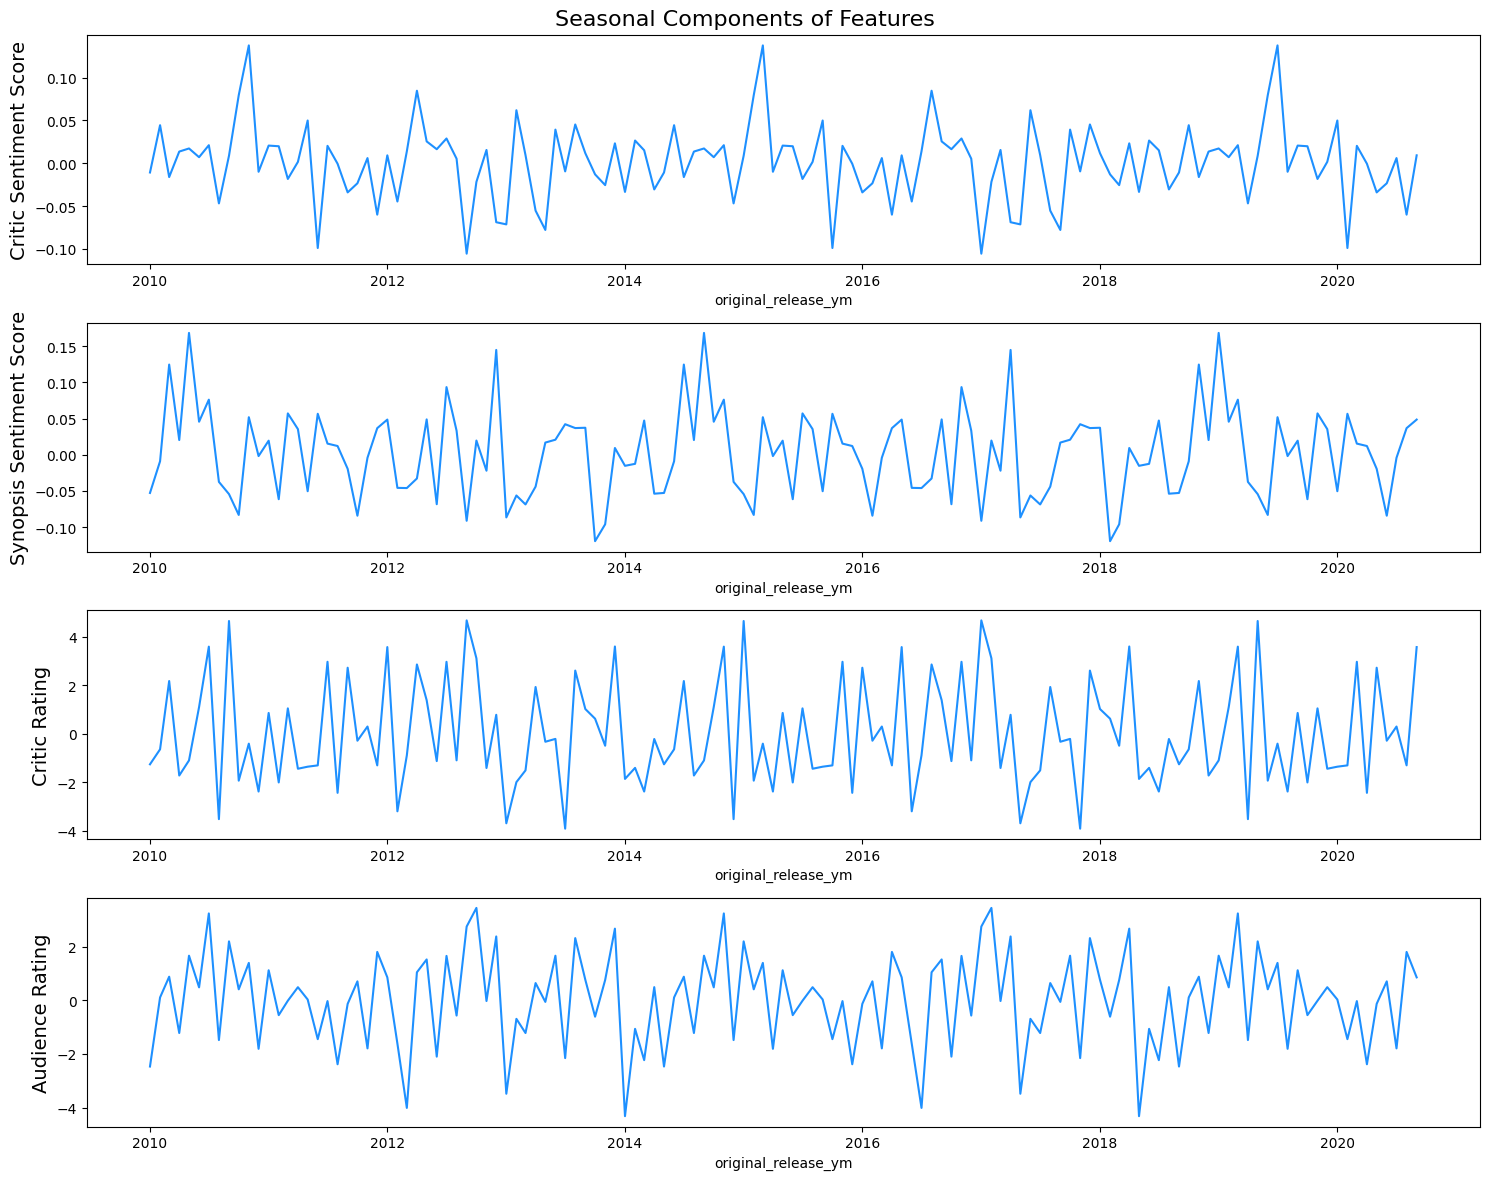

In [83]:
filtered_df = ym_df[ym_df['original_release_ym']>='2010-01-01']

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=filtered_df.original_release_ym, y=filtered_df.critic_sentiment_score_seasonal, ax=ax[0], color='dodgerblue')
ax[0].set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

sns.lineplot(x=filtered_df.original_release_ym, y=filtered_df.synopsis_sentiment_score_seasonal, ax=ax[1], color='dodgerblue')
ax[1].set_ylabel(ylabel='Synopsis Sentiment Score', fontsize=14)

sns.lineplot(x=filtered_df.original_release_ym, y=filtered_df.tomatometer_rating_seasonal, ax=ax[2], color='dodgerblue')
ax[2].set_ylabel(ylabel='Critic Rating', fontsize=14)

sns.lineplot(x=filtered_df.original_release_ym, y=filtered_df.audience_rating_seasonal, ax=ax[3], color='dodgerblue')
ax[3].set_ylabel(ylabel='Audience Rating', fontsize=14)

plt.tight_layout()
plt.show()

We can see that the correlation to the target variables increases if we use the time shifted features in comparison to the original features.

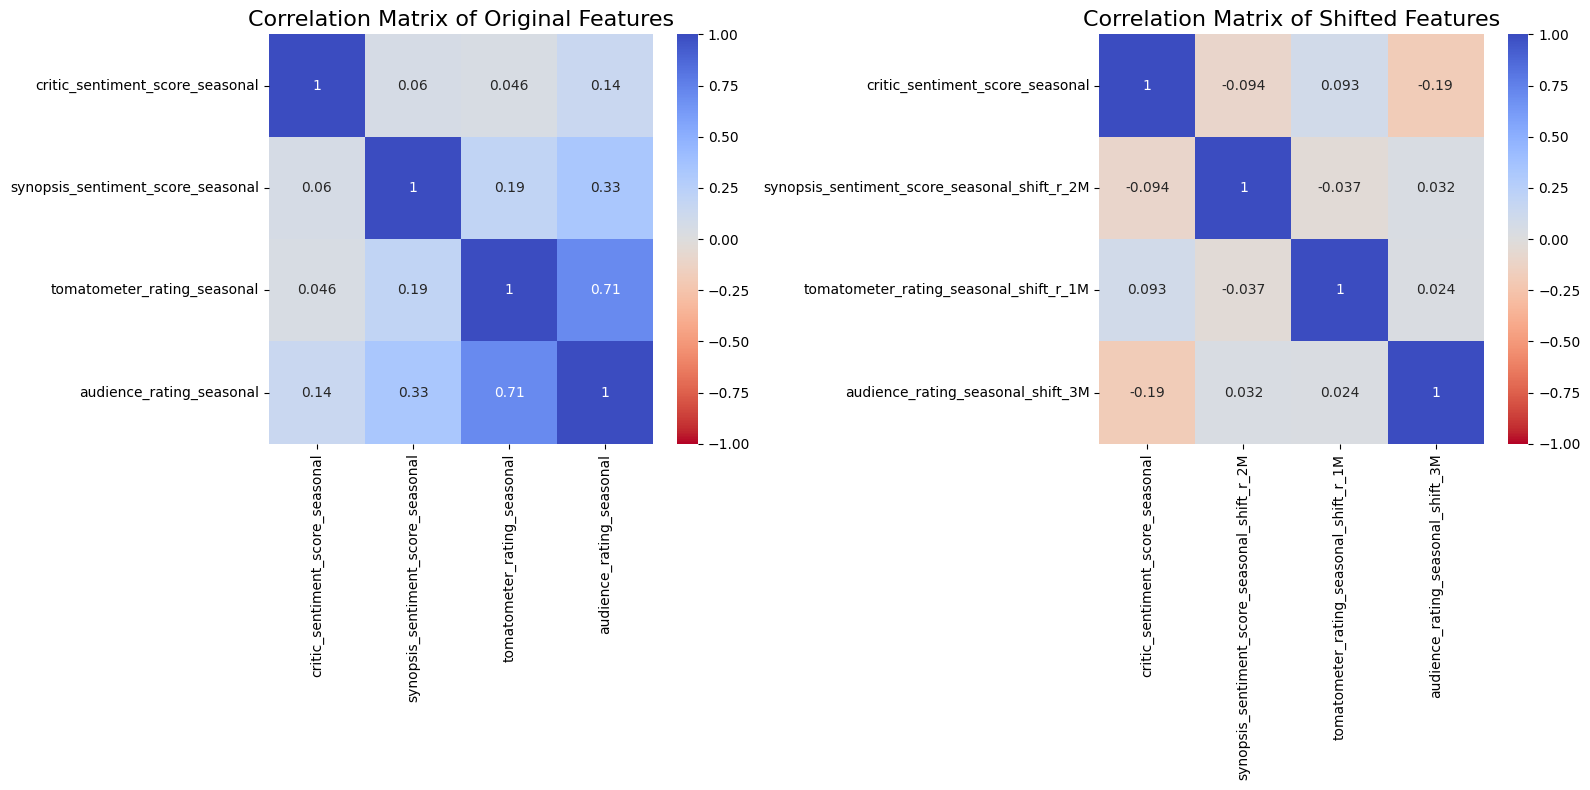

In [85]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols = ['critic_sentiment_score_seasonal', 
                 'synopsis_sentiment_score_seasonal',
                 'tomatometer_rating_seasonal', 
                 'audience_rating_seasonal']

corrmat = ym_df[original_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)

shifted_cols = [ 'critic_sentiment_score_seasonal', 
                'synopsis_sentiment_score_seasonal_shift_r_2M',
                'tomatometer_rating_seasonal_shift_r_1M', 'audience_rating_seasonal_shift_3M']
corrmat = ym_df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)


plt.tight_layout()
plt.show()

### Autocorrelation Analysis¶

Autocorrelation Function (ACF): Correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1. -> (MA parameter is q significant lags)

Partial Autocorrelation Function (PACF): Additional correlation explained by each successive lagged term -> (AR parameter is p significant lags)
Autocorrelation helps in detecting seasonality.

As we can infer from the graph below, the autocorrelation continues to decrease as the lag increases, confirming that there is no linear association between observations separated by larger lags.

For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots, meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend.

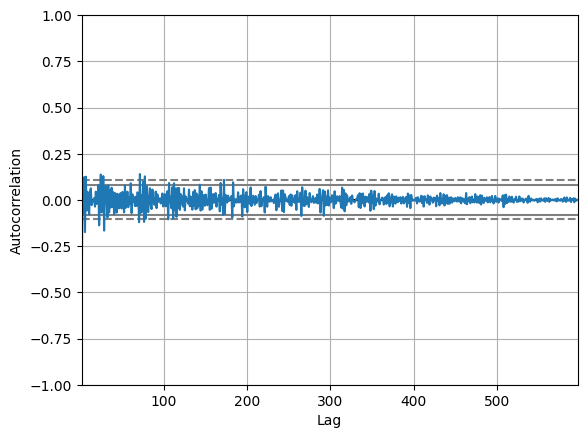

In [88]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ym_df.tomatometer_rating_diff1)
plt.show()

We can see some sinusoidal shape in both ACF and PACF functions. This suggests that both AR and MA processes are present.

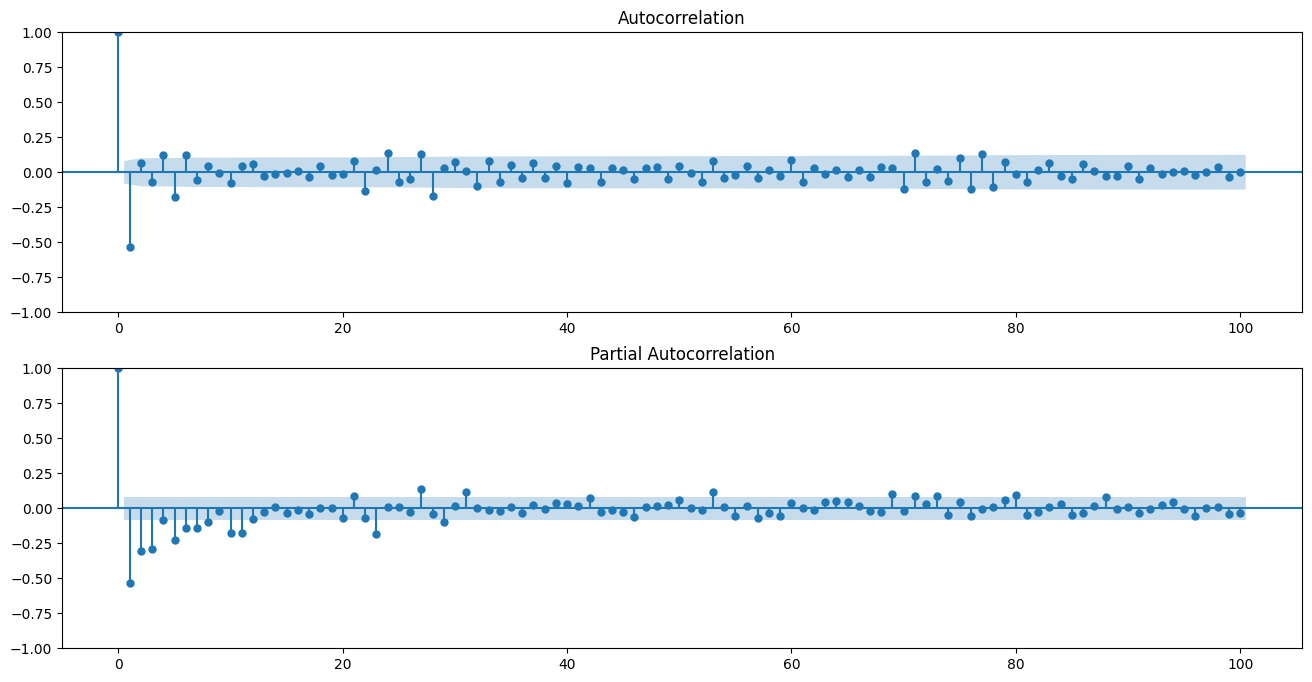

In [89]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(ym_df.tomatometer_rating_diff1,lags=100, ax=ax[0])
plot_pacf(ym_df.tomatometer_rating_diff1,lags=100, ax=ax[1])
plt.show()

# Cross Validation